In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
import utils

In [2]:
ROOT_PATH = Path('data/q3')
CORRESP1_DATA_PATH = ROOT_PATH / 'pts1.npy'
CORRESP2_DATA_PATH = ROOT_PATH / 'pts2.npy'
PROJECTION1_PATH = ROOT_PATH / 'P1.npy'
PROJECTION2_PATH = ROOT_PATH / 'P2.npy'
IMG1_PATH = ROOT_PATH / 'img1.jpg'
IMG2_PATH = ROOT_PATH / 'img2.jpg'

In [3]:
IMG1 = utils.load_image(IMG1_PATH)
IMG2 = utils.load_image(IMG2_PATH)

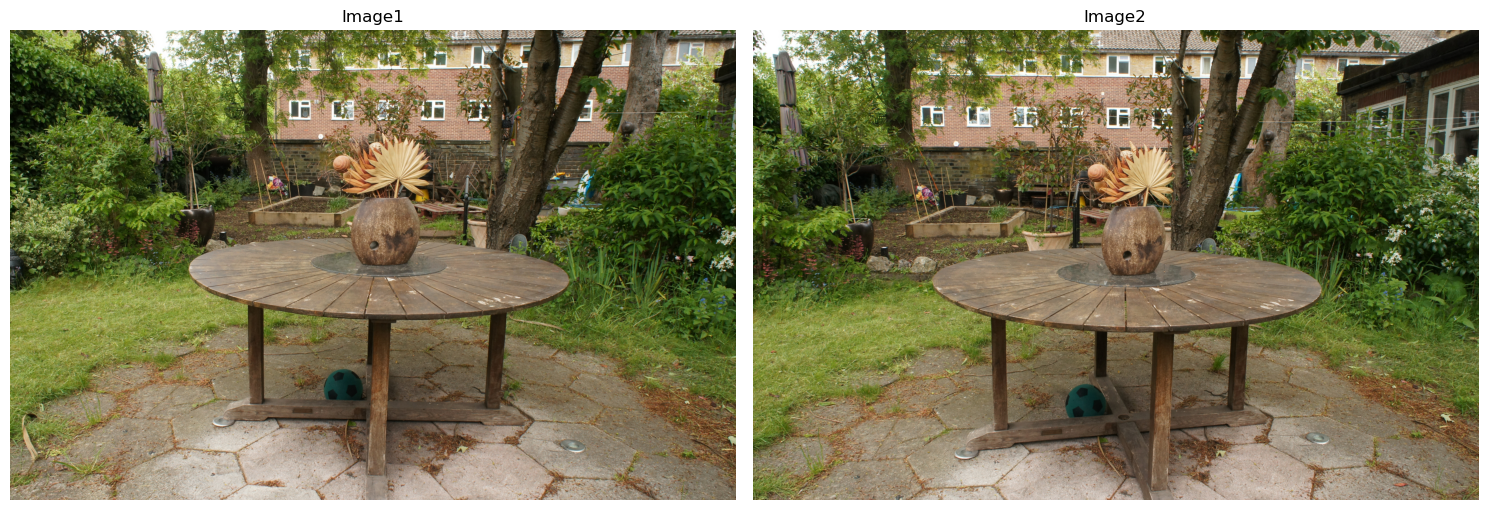

In [4]:
utils.show_images([IMG1, IMG2], ['Image1', 'Image2'])

In [5]:
P1 = np.load(PROJECTION1_PATH)
P2 = np.load(PROJECTION2_PATH)
print(f'P1: {P1.shape}\n{P1}')
print(f'P2: {P2.shape}\n{P2}')

P1: (3, 4)
[[ 4.07010660e+03  1.36505062e+03 -1.75509484e+03  9.78384847e+03]
 [ 9.10006276e+02  3.41131354e+03  2.28025369e+03 -6.91331458e+02]
 [ 8.70028577e-01 -6.60358798e-02  4.88558633e-01  3.56568286e+00]]
P2: (3, 4)
[[ 3.54894000e+03  1.74167888e+03 -2.42509142e+03  1.00736875e+04]
 [ 1.01372135e+03  3.45513437e+03  2.16775088e+03 -4.94166242e+02]
 [ 9.46943001e-01  6.94850473e-03  3.21326426e-01  3.53159956e+00]]


In [6]:
pts1 = np.load(CORRESP1_DATA_PATH)
pts2 = np.load(CORRESP2_DATA_PATH)
print(f'pts1: {pts1.shape}\n{pts1}')
print(f'pts2: {pts2.shape}\n{pts2}')

pts1: (100000, 2)
[[3373 1768]
 [1190 2829]
 [4636 2845]
 ...
 [2520 1736]
 [1375 2994]
 [2562 1767]]
pts2: (100000, 2)
[[3469 1805]
 [1157 3100]
 [4484 2737]
 ...
 [2651 1817]
 [1445 3258]
 [2717 1847]]


In [7]:
def triangulate_points(P1, P2, pts1, pts2):
    num_pts = pts1.shape[0]
    points_3d = np.zeros((num_pts, 3))

    for i in range(num_pts):
        u1, v1 = pts1[i]
        u2, v2 = pts2[i]

        A = np.array([
            u1 * P1[2, :] - P1[0, :],
            v1 * P1[2, :] - P1[1, :],
            u2 * P2[2, :] - P2[0, :],
            v2 * P2[2, :] - P2[1, :]
        ])

        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        X /= X[3]
        
        points_3d[i] = X[:3]

    return points_3d

points_3d = triangulate_points(P1, P2, pts1, pts2)

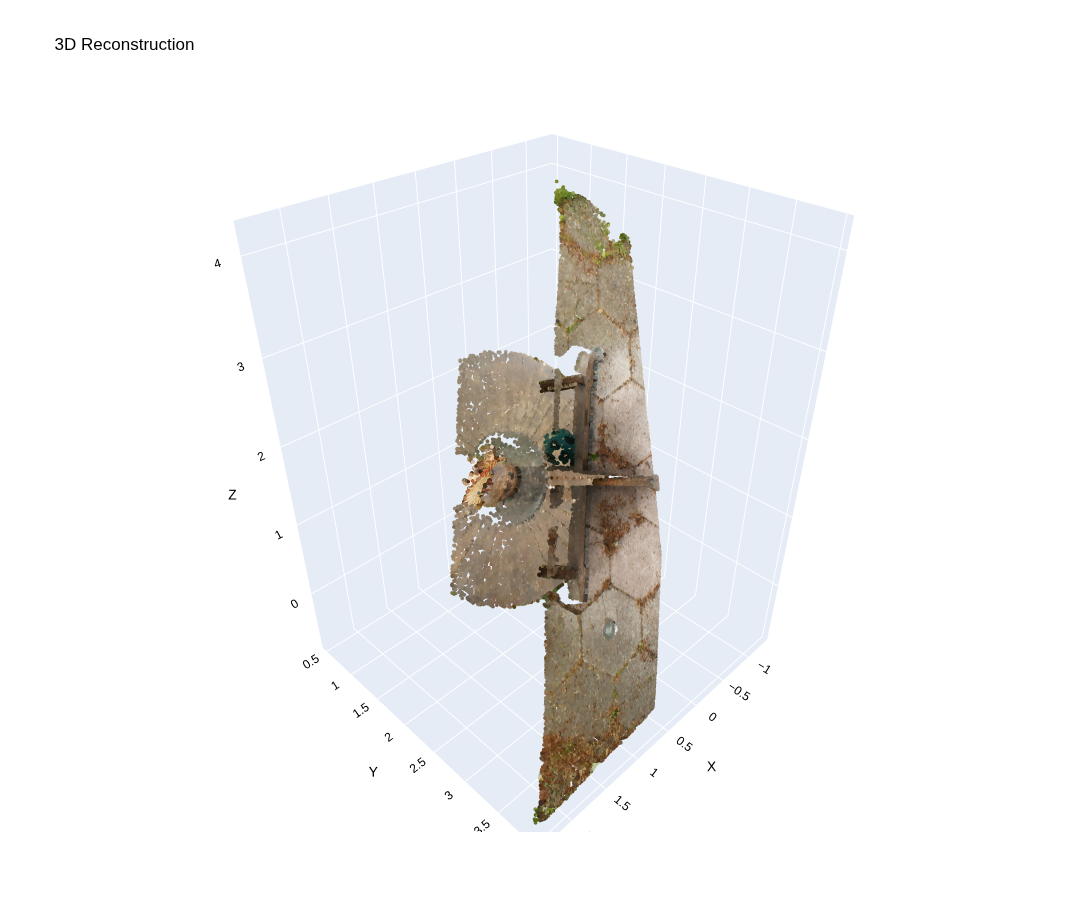

In [9]:
def get_colors_from_image(img, pts):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img_rgb.shape[:2]
    x = np.clip(pts[:, 0].astype(int), 0, w - 1)
    y = np.clip(pts[:, 1].astype(int), 0, h - 1)
    
    colors = img_rgb[y, x]
    
    color_strings = [f'rgb({r},{g},{b})' for r, g, b in colors]
    return color_strings

colors = get_colors_from_image(IMG1, pts1)

def visualize_3d_real_color(pts_3d, colors):
    fig = go.Figure(data=[go.Scatter3d(
        x=pts_3d[:, 0],
        y=pts_3d[:, 1],
        z=pts_3d[:, 2],
        mode='markers',
        marker=dict(
            size=1.2,
            color=colors,
            opacity=1.0
        )
    )])

    fig.update_layout(
        title="3D Reconstruction",
        width=1400,
        height=900,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data',
        ),
        paper_bgcolor='white',
        font_color='black'
    )
    fig.show()

visualize_3d_real_color(points_3d, colors)